In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy

SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 500
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

DC_LR = 2.5e-04
DC_EPOCH = 256

W_LR = 2.0e-04
W_EPOCH = 256
WClipLo = -0.01
WClipHi = 0.01

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)])

# Load and Preprocess Images

In [3]:
path = "/home/alexlin/alex_DL/Lab14/img_align_celeba_png/"

img_name = next(os.walk(path))[2]
img_name.sort()
print(img_name[:10])

['000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png', '000010.png']


In [4]:
def load_and_preprocessing(img_path):
    img = tf.io.read_file(path + img_path)
    img = tf.image.decode_png(img, channels=IMG_C)
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

In [6]:
iTrain = tf.data.Dataset.from_tensor_slices(img_name)
dsTrain = iTrain.map(load_and_preprocessing, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dsTrain = dsTrain.shuffle(BUF).batch(BATCH_SIZE, drop_remainder=True)

In [7]:
print(dsTrain)

<BatchDataset shapes: (500, 64, 64, 3), types: tf.float32>


# Utility function

In [8]:
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

# GAN Model

In [9]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

# Loss function of Discriminator & Generator
### Modify in Discriminator
* New_Image(c_hat) = a * Fake_Image + (1-a) * Real_Image
* gradients = gradients of New_Image in Discriminator
* gradients.shape = (BatchSize, Image.shape)
* slopes = L2 norm of gradients in each Batch
* slopes.shape = (BatchSize, 1)
* Add 10 *  (slopes - 1)^2 to Discriminator Loss


In [10]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
#optimizer_g = keras.optimizers.RMSprop(W_LR)
#optimizer_d = keras.optimizers.RMSprop(W_LR)
optimizer_g = keras.optimizers.Adam(W_LR)
optimizer_d = keras.optimizers.Adam(W_LR)

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = WG(z, training = True)
        
        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)
        
        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

    gradient_g = tpg.gradient(lg, WG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        c0 = WG(z, training = True)
        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        # Generate a for each Batch
        a = tf.random.uniform(shape=[BATCH_SIZE,1], minval=0., maxval=1.)
        a = tf.expand_dims(a, -1)
        a = tf.expand_dims(a, -1)

        # compute c_hat
        differences = c0 - c1
        c_hat = c1 + a*differences

        # compute gradients of c_hat
        gradients = tf.gradients(WD(c_hat, training = False), [c_hat])[0]

        # Do L2-norm for each Batch
        slopes = tf.square(gradients)
        slopes = tf.reduce_sum(slopes, 3)
        slopes = tf.reduce_sum(slopes, 2)
        slopes = tf.reduce_sum(slopes, 1)
        slopes = tf.sqrt(slopes)
        slopes = (slopes-1.)**2

        # compute penalty
        gradient_penalty = tf.reduce_mean(slopes)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)
        ld += 10*gradient_penalty

    gradient_d = tpd.gradient(ld, WD.trainable_variables)
    
    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))

    return lg, ld

In [11]:
# ratio of training step D:G = 5:1
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

# Train

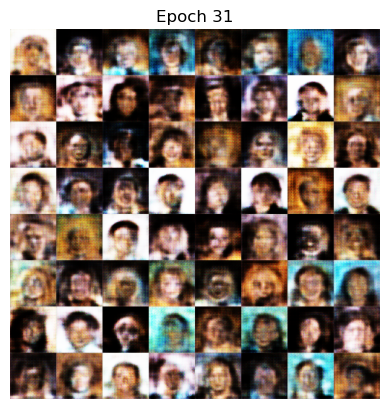

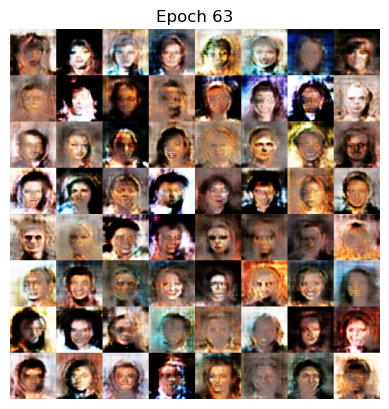

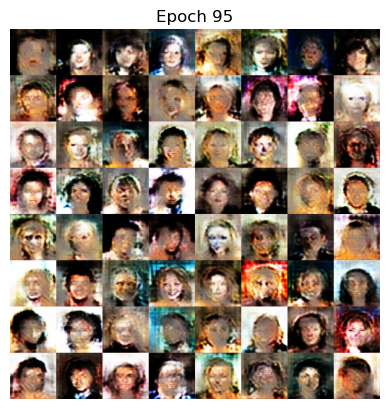

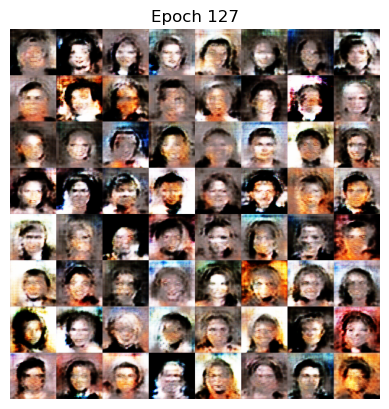

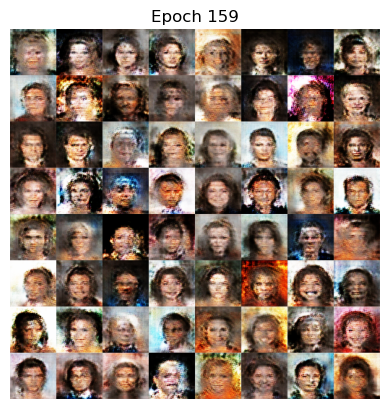

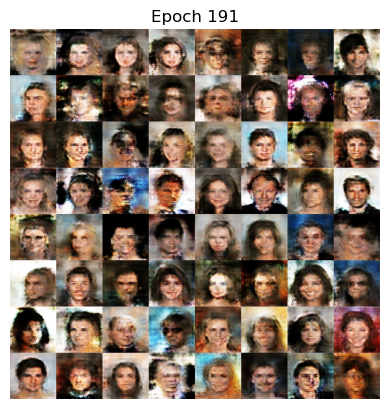

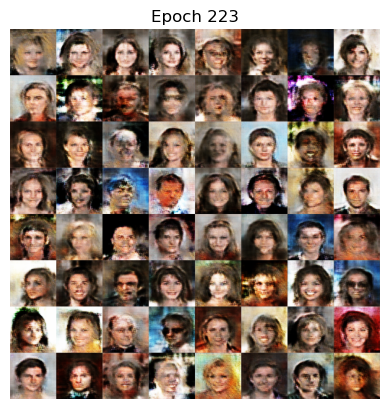

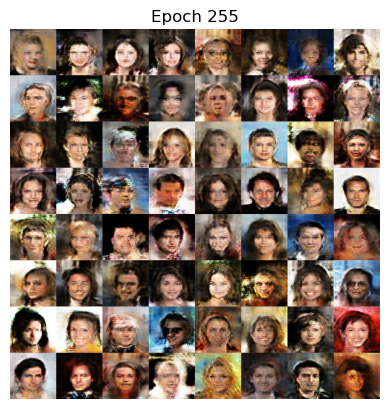

In [12]:
wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(iTrain))
ctr = 0
for ep in range(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "/home/alexlin/dl_competition/img/w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 32 == 0:
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [13]:
utMakeGif(np.array(wsp), "/home/alexlin/dl_competition/wgan-GP.gif", duration = 3)

MoviePy - Building file /home/alexlin/dl_competition/wgan-GP.gif with imageio.


# Plot Loss

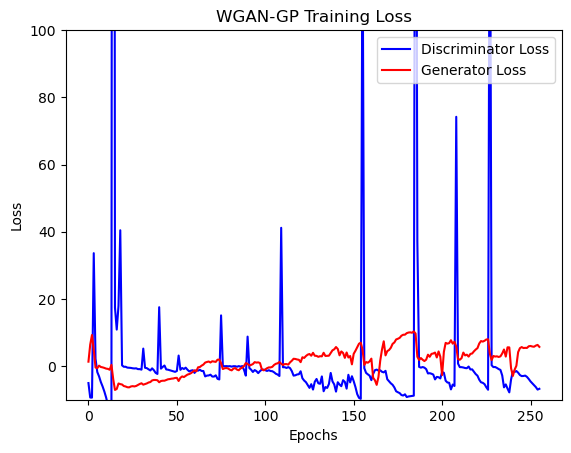

In [16]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(-10,100)
plt.title("WGAN-GP Training Loss")
plt.show()